# Урок 5. Задача оттока: варианты постановки, возможные способы решения

In [1]:
# Подключаем библиотеки
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from additional_modules import functions as func

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [2]:
df = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])
df.head(5)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2010-09-01 to 2019-09-01
Data columns (total 11 columns):
Значение           2667 non-null float64
year               2667 non-null int64
month              2667 non-null int64
dayofmonth         2667 non-null int64
quarter            2667 non-null int64
dayofyear          2667 non-null int64
weekofyear         2667 non-null int64
dayofweek          2667 non-null int64
is_holiday         2667 non-null int64
is_prev_holiday    2667 non-null int64
is_next_holiday    2667 non-null int64
dtypes: float64(1), int64(10)
memory usage: 250.0 KB


In [4]:
df['diff'] = 0
df['diff'] = df['diff'].astype('float')
df['diff'].values[1 : ] = df['Значение'].values[1:] - df['Значение'].values[:-1]
df['diff'].head()


Дата
2010-09-01    0.00
2010-09-02    0.52
2010-09-03   -0.32
2010-09-04    0.05
2010-09-05    0.01
Name: diff, dtype: float64

## 2. сделайте ее перрасчет (ресемплинг) в представление по неделям

In [5]:
df_week = df.resample('W').mean()
df_week.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff
Дата,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,0.052000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667,0.288333
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000,-0.021667
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000,0.118333
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000,0.791667


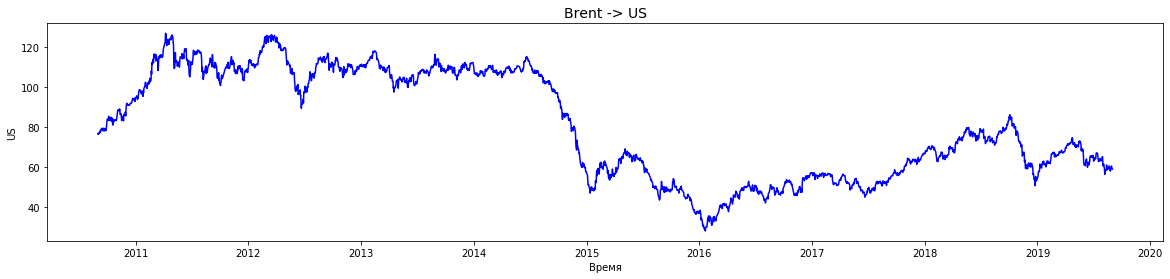

In [6]:
plt.figure(figsize =(20, 4))
plt.plot(df.index, df['Значение'], 'b' )
plt.title('Brent -> US', size=14)
plt.xlabel('Время')
plt.ylabel('US')
plt.show()

In [7]:
func.count_is_null_and_duplicate(df_week)

Пустые значения!
Значение           1
year               1
month              1
dayofmonth         1
quarter            1
dayofyear          1
weekofyear         1
dayofweek          1
is_holiday         1
is_prev_holiday    1
is_next_holiday    1
diff               1
dtype: int64
------------------------------
Количество дубликатов: 0


In [8]:
null_list = func.view_null_values(df_week, 'Значение')

            Значение  year  month  dayofmonth  quarter  dayofyear  weekofyear  \
Дата                                                                            
2011-10-16       NaN   NaN    NaN         NaN      NaN        NaN         NaN   

            dayofweek  is_holiday  is_prev_holiday  is_next_holiday  diff  
Дата                                                                       
2011-10-16        NaN         NaN              NaN              NaN   NaN  
------------------------------
Список индексов пустых:
[Timestamp('2011-10-16 00:00:00', freq='W-SUN')]


In [9]:
df_week = func.remove_nan_or_dup_values(df_week, null_list)

In [10]:
func.count_is_null_and_duplicate(df_week)

Пустые значения!
Значение           0
year               0
month              0
dayofmonth         0
quarter            0
dayofyear          0
weekofyear         0
dayofweek          0
is_holiday         0
is_prev_holiday    0
is_next_holiday    0
diff               0
dtype: int64
------------------------------
Количество дубликатов: 0


## 3. Добавьте первые разности по стоимости доллара и евро к рублю.

In [11]:
r_u = pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx', index_col=[1], parse_dates=[1])
r_u.drop(['nominal','cdx'], axis = 1, inplace = True)
r_u.head()

,curs
data,
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [12]:
r_u_week = r_u.copy().resample('W').mean()
r_u_week.head()

,curs
data,
2010-09-05,30.76125
2010-09-12,30.79402
2010-09-19,30.84672
2010-09-26,30.99920
2010-10-03,30.52764


In [13]:
func.count_is_null_and_duplicate(r_u_week)
na_list = func.view_null_values(r_u_week, 'curs')

Пустые значения!
curs    8
dtype: int64
------------------------------
Количество дубликатов: 7
            curs
data            
2011-01-09   NaN
2012-01-08   NaN
2013-01-06   NaN
2015-01-11   NaN
2016-01-10   NaN
2017-01-08   NaN
2018-01-07   NaN
2019-01-06   NaN
------------------------------
Список индексов пустых:
[Timestamp('2011-01-09 00:00:00'), Timestamp('2012-01-08 00:00:00'), Timestamp('2013-01-06 00:00:00'), Timestamp('2015-01-11 00:00:00'), Timestamp('2016-01-10 00:00:00'), Timestamp('2017-01-08 00:00:00'), Timestamp('2018-01-07 00:00:00'), Timestamp('2019-01-06 00:00:00')]


In [14]:
# т.к. дубликаты найдены только по пустым значениям, то достаточно только разобраться с ними
func.remove_nan_or_dup_values(r_u_week, na_list)
func.count_is_null_and_duplicate(r_u_week)

Пустые значения!
curs    0
dtype: int64
------------------------------
Количество дубликатов: 0


In [15]:
r_u_week.loc[1:, 'usd_diff'] = r_u_week['curs'].values[1:] - r_u_week['curs'].values[:-1]
r_u_week.head()

,curs,usd_diff
data,,
2010-09-05,30.76125,NaN
2010-09-12,30.79402,0.03277
2010-09-19,30.84672,0.05270
2010-09-26,30.99920,0.15248
2010-10-03,30.52764,-0.47156


In [16]:
r_u_week['usd_diff'].fillna(0, inplace = True)
r_u_week.head()

,curs,usd_diff
data,,
2010-09-05,30.76125,0.00000
2010-09-12,30.79402,0.03277
2010-09-19,30.84672,0.05270
2010-09-26,30.99920,0.15248
2010-10-03,30.52764,-0.47156


In [17]:
r_e = pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx', index_col=[1], parse_dates=[1])
r_e.drop(['nominal','cdx'], axis = 1, inplace = True)
r_e.head()

,curs
data,
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [18]:
r_e_week = r_e.copy().resample('W').mean()
r_e_week.head()

,curs
data,
2010-09-05,39.204675
2010-09-12,39.293360
2010-09-19,39.977740
2010-09-26,41.042640
2010-10-03,41.351660


In [19]:
func.count_is_null_and_duplicate(r_e_week)
na_list = func.view_null_values(r_e_week, 'curs')

Пустые значения!
curs    8
dtype: int64
------------------------------
Количество дубликатов: 7
            curs
data            
2011-01-09   NaN
2012-01-08   NaN
2013-01-06   NaN
2015-01-11   NaN
2016-01-10   NaN
2017-01-08   NaN
2018-01-07   NaN
2019-01-06   NaN
------------------------------
Список индексов пустых:
[Timestamp('2011-01-09 00:00:00'), Timestamp('2012-01-08 00:00:00'), Timestamp('2013-01-06 00:00:00'), Timestamp('2015-01-11 00:00:00'), Timestamp('2016-01-10 00:00:00'), Timestamp('2017-01-08 00:00:00'), Timestamp('2018-01-07 00:00:00'), Timestamp('2019-01-06 00:00:00')]


In [20]:
func.remove_nan_or_dup_values(r_e_week, na_list)
func.count_is_null_and_duplicate(r_e_week)

Пустые значения!
curs    0
dtype: int64
------------------------------
Количество дубликатов: 0


In [21]:
r_e_week.loc[1:, 'eur_diff'] = r_u_week['curs'].values[1:] - r_u_week['curs'].values[:-1]
r_e_week.head()

,curs,eur_diff
data,,
2010-09-05,39.204675,NaN
2010-09-12,39.293360,0.03277
2010-09-19,39.977740,0.05270
2010-09-26,41.042640,0.15248
2010-10-03,41.351660,-0.47156


In [22]:
r_e_week.fillna(0, inplace = True)
r_e_week.head()

,curs,eur_diff
data,,
2010-09-05,39.204675,0.00000
2010-09-12,39.293360,0.03277
2010-09-19,39.977740,0.05270
2010-09-26,41.042640,0.15248
2010-10-03,41.351660,-0.47156


## 4. Постройте модель предсказания 1-й точки от текущей (h = 1).

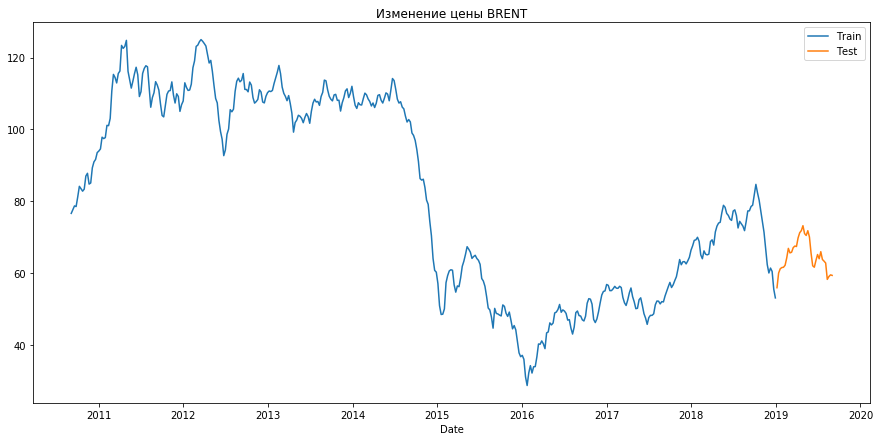

In [23]:
train, test = func.split_data(df_week, '2019-01-01')

plt.figure(figsize=(15, 7))
plt.plot(train.index, train.iloc[:, 0], label='Train')
plt.plot(test.index, test.iloc[:, 0], label='Test')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.legend(loc = 'best')
plt.show()

In [24]:
h = 1

X_train = train.iloc[: -h, :]
y_train = train['Значение'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['Значение'].values[h:]

In [25]:
model_gbr = GradientBoostingRegressor(max_depth = 15, random_state = 0, n_estimators = 100)
model_gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=15, random_state=0)

In [26]:
y_test_pred = model_gbr.predict(X_test)

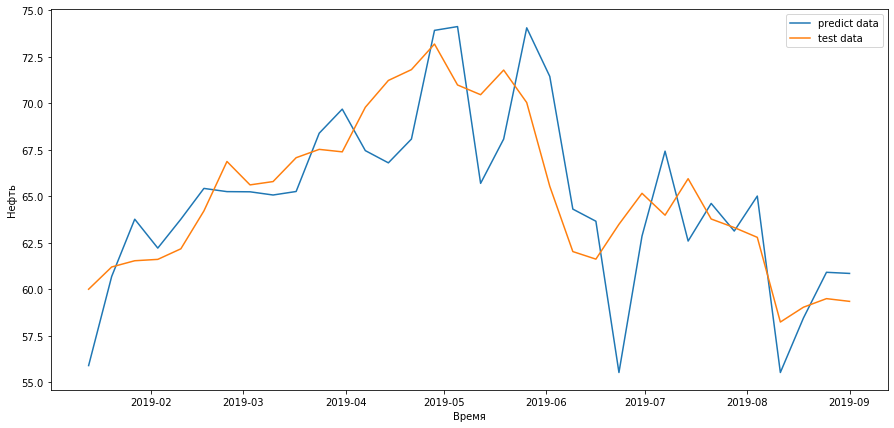

In [27]:
plt.figure(figsize=(15, 7))


plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(test.index[h:],y_test_pred, label='predict data' )
plt.plot(test.index[h:],y_test, label='test data')

plt.legend()
plt.show()

In [28]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred)
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred)

print(f"Ошибка mse: {er_s}\nОшибка mae: {er_a}\nОценка R2: {er_r2}")

Ошибка mse: 8.678701738011306
Ошибка mae: 2.3998872358416454
Оценка R2: 0.4929029438324479


In [29]:
er_g = func.mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Ошибка градиентного бустинга MAPE: {round(er_g, 2)}%")

Ошибка градиентного бустинга MAPE: 3.66%


In [47]:
param_dist = {
    "max_depth": [3, 2, 1, 4, 5, 10],
    "n_estimators": [100, 200, 300, 400, 500, 900]
}

n_iter_search = 20

model_gr = GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions = param_dist, n_iter = n_iter_search, cv = 5, iid = False)

random_search.fit(X_train, y_train)

func.report(random_search.cv_results_, len(param_dist['max_depth']))


Model with rank: 1
Mean validation score: 0.755 (std: 0.286)
Parameters: {'n_estimators': 300, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.746 (std: 0.280)
Parameters: {'n_estimators': 300, 'max_depth': 2}

Model with rank: 3
Mean validation score: 0.746 (std: 0.300)
Parameters: {'n_estimators': 500, 'max_depth': 1}

Model with rank: 4
Mean validation score: 0.740 (std: 0.274)
Parameters: {'n_estimators': 900, 'max_depth': 2}

Model with rank: 5
Mean validation score: 0.740 (std: 0.285)
Parameters: {'n_estimators': 300, 'max_depth': 3}

Model with rank: 6
Mean validation score: 0.739 (std: 0.240)
Parameters: {'n_estimators': 300, 'max_depth': 10}



In [48]:
model_gbr_opt = GradientBoostingRegressor(max_depth = 1, random_state = 0, n_estimators = 500)

In [49]:
model_gbr_opt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=1, n_estimators=500, random_state=0)

In [50]:
y_test_pred = model_gbr_opt.predict(X_test)

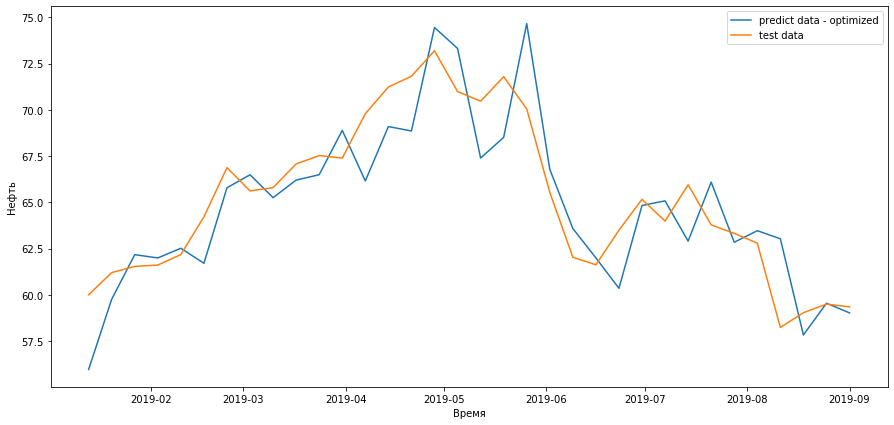

In [51]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(test.index[h:],y_test_pred, label='predict data - optimized' )
plt.plot(test.index[h:],y_test, label='test data')

plt.legend()
plt.show()

In [53]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred)
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred)

print(f"Ошибка mse: {er_s}\nОшибка mae: {er_a}\nОценка R2: {er_r2}")

Ошибка mse: 4.761142996412248
Ошибка mae: 1.7405970686624015
Оценка R2: 0.7218061329497134


In [54]:
er_g = func.mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Ошибка градиентного бустинга MAPE: {round(er_g, 2)}%")

Ошибка градиентного бустинга MAPE: 2.65%


## 5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

Судя по ошибкам, дневные данные значительно выше недельных. Хотя при проверке ошибки разница ~1%. По значениям R2 значения довольно таки большие для раночной цены.

